
# Range-Doppler Processing using FMCW Radar <img style="float: right; width: 160px" src="../images/logo-2pi-labs.png">
--- 
<img style="float: right; height: 50px; padding-right: 15px" src="../images/cc-by-nc-sa.eu.png">

**Author**: Simon Kueppers, 2pi-Labs GmbH \
**License**: Creative Commons [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) 






<img src="../images/rd-example.png" width="100%">

In the following, we will examine range-doppler processing for FMCW radar systems. Range-doppler processing is often used to analyze dynamic scenes with moving targets to get a better understanding of how far targets are located and how fast they are moving towards or away from the measurement system.

The processing exploit information available in a series of measurements where each *pulse* (or sweep) is acquired by the radar system with a repetition period of $T_{PR}$. In this context, an often used term is the *pulse repetition frequency* or $\text{PRF}=F_{PR}=1/T_{PR}$. By acquiring multiple equidistant measurements with a fixed and known time period, we can deduce the speed of all the targets visible by the radar sensor.

In the following, we load a pre-recoded sample dataset of a target moving towards the radar system with a constant speed of 100mm/s.

In [1]:
from twopilabs.sense.x1000 import SenseX1000
import h5py

# Use SenseX1000 facilities to load a recorded hdf5 dataset
# These commands traverse two hierarchy layers in the hdf5 structure and load the first recording
h5file = h5py.File('../data/rd-data-100mmps-towards-normal.h5', 'r')
h5supergroup = list(h5file.values())[0]
h5group = list(h5supergroup.values())[0]
h5name = list(h5group.keys())[0]
data = SenseX1000.AcqData.from_hdf5(h5group, h5name)

# Normalize the amplitude of data points to [-1,1] by dividing with the maximum magnitude of the data type 
sweep_data = data.array / data.header.acq_dtype.info.mag

# Drop all but the first trace in our recording to make things easier. We only have recorded a single trace anyway.
sweep_data = sweep_data[:,0,:]

In [2]:
# Lets look at the loaded data
print(f'trigger timestamp: {data.header.trig_timestamp}')
print(f'sweep count:       {data.header.sweep_count}')
print(f'trace count:       {data.header.trace_count}')
print(f'data points:       {data.header.data_points}')
print(f'sweep period:      {data.header.sweep_period}')
print(f'sweep duration:    {data.header.time_axis[-1]-data.header.time_axis[0]} seconds')
print(f'sweep frequencies: {data.header.freq_axis[0]/1e9:.1f} GHz to {data.header.freq_axis[-1]/1e9:.1f} GHz')
print(f'data array shape:  {data.array.shape} (N_sweeps x N_traces x N_points)')
print(f'data point type:   {data.header.acq_dtype.name} (Numpy: {data.header.acq_dtype.info.np})')


trigger timestamp: 2023-01-13T14:32:36.667159960
sweep count:       4000
trace count:       1
data points:       1001
sweep period:      500000 nanoseconds
sweep duration:    0.0002 seconds
sweep frequencies: 126.0 GHz to 148.5 GHz
data array shape:  (4000, 1, 1001) (N_sweeps x N_traces x N_points)
data point type:   S16RLE (Numpy: int16)


As can be seen, the recorded data reflect a series of measurements with $N_{sweeps}=4000$ sweeps per one acquisition, each sweep consisting of $N_{points}=1001$ points from $N_{trace}=1$ traces (or *channels*). Each sweep runs from $f_{start}=126\text{GHz}$ to $f_{stop}=148.5\text{GHz}$ (resulting in a occupied bandwidth of $f_{BW}=22.5\text{GHz}$). Each sweep is repeated with a period of $T_{PR}=500*10^{-6}$ seconds and is of ``int16`` signed 16-bit integer type (real valued little-endian).

The data array contains data from all points in all sweeps. In the following code, we first employ the classical FFT processing for all sweeps in the dataset, to convert each measurement from sweep domain into the range domain.

## Viewing the Dataset in Range Domain

In [3]:
import scipy.signal
import numpy as np

# Apply window function to reduce sidelobing during FFT processing
window_data = scipy.signal.windows.get_window('hann', data.n_points, fftbins=True)  # define "periodic" window

# Multiply data with window function
sweep_data_windowed = sweep_data * window_data

# Run 1D FFT across the last dimension to transform every sweep in the 2D dataset from sweep to range domain
range_data = np.fft.ifftn(sweep_data_windowed, s=[data.n_points], axes=[-1])

Let's go ahead and examine the dataset resulting from the above operations. Since the dataset is 2D, we choose to use a color-coded 2D plot. The X-axis represents the range domain, the Y axis iterates through all measurements in the acquisition and the color encodes the log-abs Amplitude.

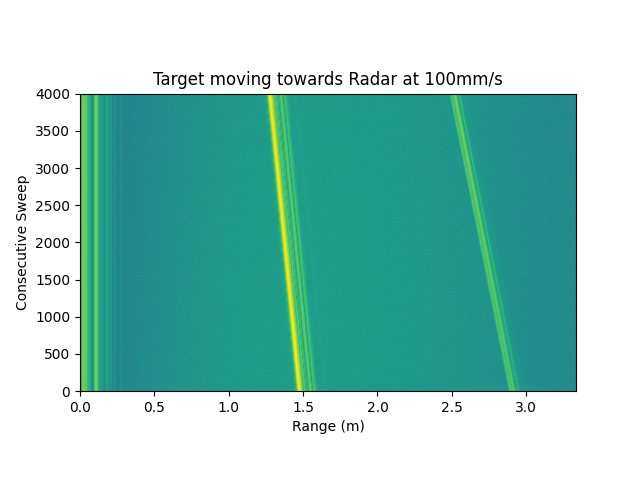

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import scipy.constants as const

# Calculate the extent of the 2D image, first the range axis, second the sweeps axis.
# Range is calculated from the time the signal takes to get to the target and back (round-trip time)
# The round-trip time is defined as the reciprocal of the sweep-frequency delta (delta F per point)
# However since we are only plotting half of the symmetric spectrum, the total extent of the X axis is halved

extent = [ 0, 0.5 / abs(data.header.freq_step) * const.c / 2,
           0, range_data.shape[0] ]

plt.imshow(20*np.log10(np.abs(range_data[:,0:range_data.shape[-1]//2])), extent=extent, origin='lower', aspect=.0005)
plt.xlabel('Range (m)')
plt.ylabel('Consecutive Sweep')
plt.title('Target moving towards Radar at 100mm/s');

The 2D image shows a few interesting characteristics. Firstly, around a range of 0.0m, static reflections generated within the radar system can be seen. These reflections are parasitic (i.e. unwanted) and it is possible to remove them, however this is currently not the focus of this example. 

Next, when looking from consecutive sweep 0 to last, the main target at around 1.5m (initially) can be seen, moving towards the radar system (located at 0.0m) with to a final distance of around 1.3m.

Thirdly, a multiple-reflection can be observed at around twice the distance of the main target. Note that the distance difference from beginning and end of the acquisition is twice than of the main target.

## Arriving at a Range-Doppler Representation of The Scene
Range-Doppler processing allows to essentially *compress* the Y-Axis of Figure 1 above into a velocity axis by performing a Fourier Transform along the Y-Axis. This essentially decomposes the time-varying data into their frequency contents, which are directly linear to the velocity.

In Range-Doppler context, these two dimensions are often referred to as fast-time and slow-time dimensions, named after how fast they are acquired by the radar system.

In [5]:
# Apply window function to reduce sidelobing during FFT processing
window_data = scipy.signal.windows.get_window('hann', data.n_sweeps, fftbins=True)  # define "periodic" window

# Multiply with window function, we need to multiple along the first axis, temporarily transpose for multiplication
range_data_windowed = (range_data.T * window_data).T

# Apply slow-time fourier transform
range_doppler_data = np.fft.ifftn(range_data_windowed, s=[data.n_sweeps], axes=[0])

# range_doppler_data is a double-sided spectrum, due to the complex valued input data to the second FFT.
# We shift the spectrum to move the zero-frequency component to the center, as we would expect
range_doppler_data = np.fft.fftshift(range_doppler_data, axes=[0])

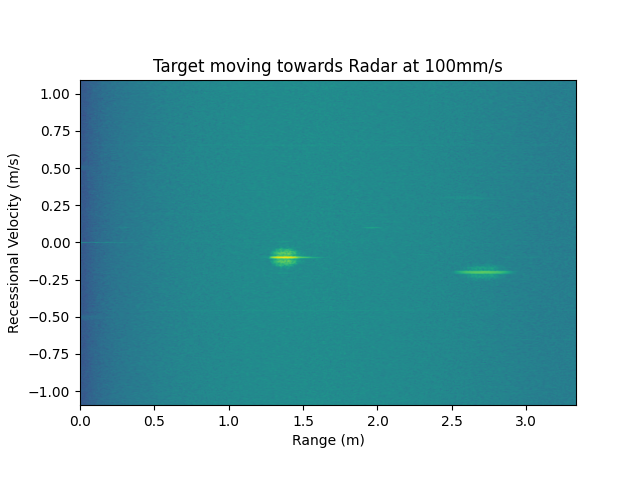

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt

# Calculate the extent of the 2D image, range axis (fast-time) will be taken from above
# Slow-time axis is calculated using PRF
prf = np.timedelta64(1, 's') / data.header.sweep_period # PRF in 1/s as float
fcenter = np.mean(data.header.freq_axis)
extent = [ 0, 0.5 / abs(data.header.freq_step) * const.c / 2,
           -0.5 * prf * const.c / 2 / fcenter, 0.5 * prf * const.c / 2 / fcenter ]

plt.imshow(20*np.log10(np.abs(range_doppler_data[:, 0:range_doppler_data.shape[-1]//2])), extent=extent, origin='lower', aspect=1)
plt.xlabel('Range (m)')
plt.ylabel('Recessional Velocity (m/s)')
plt.title('Target moving towards Radar at 100mm/s');

After all the processing, we have produced our first range-doppler plot. As you can see, the target has been *compressed* along the Y-axis showing a distinct peak at the mean distance of $R_m=(1.5\text{m}-1.3\text{m})/2=1.4\text{m}$ during the observational interval. On the Y-axis, the maxium of the peak is located at -0.1m/s as expected.

Note also, that the multiple reflection, that we have already observed before is located not only at around twice the distance, but also twice the velocity, due to the signal going back and forth two times total. 

## Resolution Trade-Offs
At this point, you will probably notice that the processing we have done is quite *static*. We used a lot of sweeps just to produce the above shown range-doppler plot. As a result you will notice that the resolution of thes slow-time dimension (Y-axis) is quite high, if you take a closer look into the plot. However the downside of doing this is, that we do not get a lot (in fact we don't get any) resolution in time. In effect, we get the average velocity information from a duration of $N_{sweeps}*T_{PR}=2  \text{sec}$ squished into a single plot. Note that the processing above also assumes that the first derivative of the velocity (i.e. acceleration) is zero and thus the velocity constant.

You might ask, what we can do to trade-off slow-time resolution for resolution in time, e.g. to generate multiple range-doppler plots of a target with changing velocity over time. In the following, we will load a pre-recorded dataset with a target oscillating between two positions. We will process this data into multiple range-doppler plots to show the varying nature of the target velocity.


In [7]:
from twopilabs.sense.x1000 import SenseX1000
import h5py

# Use SenseX1000 facilities to load a recorded hdf5 dataset
# These commands traverse two hierarchy layers in the hdf5 structure and load the first recording
h5file = h5py.File('../data/rd-data-100mmps-oscillating-normal.h5', 'r')
h5supergroup = list(h5file.values())[0]
h5group = list(h5supergroup.values())[0]
h5name = list(h5group.keys())[0]
data = SenseX1000.AcqData.from_hdf5(h5group, h5name)

# Normalize the amplitude of data points to [-1,1] by dividing with the maximum magnitude of the data type 
sweep_data = data.array / data.header.acq_dtype.info.mag

# Drop all but the first trace in our recording to make things easier. We only have recorded a single trace anyway.
sweep_data = sweep_data[:,0,:]

In [8]:
# Lets look at the loaded data
print(f'trigger timestamp: {data.header.trig_timestamp}')
print(f'sweep count:       {data.header.sweep_count}')
print(f'trace count:       {data.header.trace_count}')
print(f'data points:       {data.header.data_points}')
print(f'sweep period:      {data.header.sweep_period}')
print(f'sweep duration:    {data.header.time_axis[-1]-data.header.time_axis[0]} seconds')
print(f'sweep frequencies: {data.header.freq_axis[0]/1e9:.1f} GHz to {data.header.freq_axis[-1]/1e9:.1f} GHz')
print(f'data array shape:  {data.array.shape} (N_sweeps x N_traces x N_points)')
print(f'data point type:   {data.header.acq_dtype.name} (Numpy: {data.header.acq_dtype.info.np})')


trigger timestamp: 2023-01-13T14:37:53.726539976
sweep count:       20000
trace count:       1
data points:       1001
sweep period:      500000 nanoseconds
sweep duration:    0.0002 seconds
sweep frequencies: 126.0 GHz to 148.5 GHz
data array shape:  (20000, 1, 1001) (N_sweeps x N_traces x N_points)
data point type:   S16RLE (Numpy: int16)


This time, the loaded dataset has $N_{sweeps}=20000$ sweep points, corresponding to an acquisition duration of $N_{sweeps}*T_{PR}=10\text{sec}$. Plenty of data to perform our range-doppler processing. The other settings are similar to above.

To make the data processing more interesting, we will take some shortcuts in processing as you will see, making it a little bit faster and more concise.

In [9]:
# First of all, we divide our dataset up into chunks to get us (more) resolution in time
chunk_length = 100
sweep_data_chunked = sweep_data.reshape([-1, chunk_length, data.header.data_points])

print(f'previous shape:      {sweep_data.shape}')
print(f'new (chunked) shape: {sweep_data_chunked.shape}')

previous shape:      (20000, 1001)
new (chunked) shape: (200, 100, 1001)


In [10]:
import scipy
import numpy as np

# We now perform range-doppler processing with the last two dimensions being slow-time and fast-time respectively.
# Apply window function and scale amplitude correctly with regards to window size and fft length
windows = ['hann', # slow-time window
           'hann'] # fast-time window 

window_data_st = scipy.signal.windows.get_window(windows[0], sweep_data_chunked.shape[1], fftbins=True)  # define "periodic" window
window_data_ft = scipy.signal.windows.get_window(windows[1], sweep_data_chunked.shape[2], fftbins=True)  # define "periodic" window

# Create a 2D window function matrix
sweep_data_windowed = sweep_data_chunked * np.outer(window_data_st, window_data_ft)

# Apply 2D discrete fourier transform on slow-time and fast-time dimensions simultaneously
range_doppler_data = np.fft.ifftn(sweep_data_windowed, axes=[1, 2])

# Again, shift the spectrum to move the zero-frequency component to the center of the slow-time axis
range_doppler_data = np.fft.fftshift(range_doppler_data, axes=[1])

interactive(children=(Play(value=0, description='x', max=199), Output()), _dom_classes=('widget-interact',))

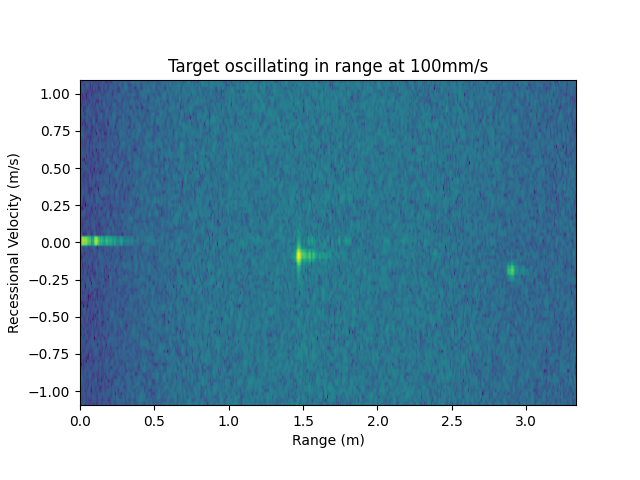

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import scipy.constants as const
from ipywidgets import interact, Play

# Calculate the extent of the 2D image, range axis (fast-time) will be taken from above
# Slow-time axis is calculated using PRF
prf = np.timedelta64(1, 's') / data.header.sweep_period # PRF in 1/s as float
fcenter = np.mean(data.header.freq_axis)
extent = [ 0, 0.5 / abs(data.header.freq_step) * const.c / 2,
           -0.5 * prf * const.c / 2 / fcenter, 0.5 * prf * const.c / 2 / fcenter ]

@interact(x=Play(value=0, min=0, max=range_doppler_data.shape[0]-1, step=1))
def g(x):
    plt.imshow(20*np.log10(np.abs(range_doppler_data[x,:, 0:range_doppler_data.shape[-1]//2])), extent=extent, origin='lower', aspect=1)
    plt.xlabel('Range (m)')
    plt.ylabel('Recessional Velocity (m/s)')
    plt.title('Target oscillating in range at 100mm/s');

As you can see, we arrive at the same range-doppler plot as shown previously, however with a noticably coarser resolution of the velocity axis. The advantage of this is however, that we can multiple range-doppler plots available, for different points in time. Just use the slider and scroll through the plots and you will see.